## Project Work

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import gradio as gr
from torchvision import models
from torchvision.transforms import Compose, Resize, ToTensor
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader


c:\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Preparing the Dataset and Data Loaders

**Image Transformations:**

- Defines a series of transformations (transform) to be applied to the images, including resizing them to 128x128 pixels and converting them to tensors using ToTensor().

**Loading Datasets:**

- Loads the training dataset from the directory 'tree_train_set' and the validation dataset from 'tree_test_set' using ImageFolder. The specified transformations are applied to each image as they are loaded.

**Display Classes:**

- Prints the names of the classes (categories) in the training dataset using train_data.classes.

**Creating Data Loaders:**

- Creates data loaders (train_loader and val_loader) for the training and validation datasets, respectively, with a batch size of 16. The training data is shuffled, while the validation data is not.

**Display Sample Counts:**

- Prints the number of samples in the training and validation datasets using len(train_data) and len(val_data).


**`Overall, this code prepares the image datasets for training a machine learning model, ensuring images are the correct size and in tensor format for processing.`**

In [3]:
# Transformations (from your lab)
transform = Compose([Resize((128, 128)), ToTensor()])

# Load the dataset
train_data = ImageFolder(root='tree_train_set', transform=transform)
val_data = ImageFolder(root='tree_test_set', transform=transform)
print('Classes:', train_data.classes)
# Create data loaders
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
val_loader = DataLoader(val_data, batch_size=16, shuffle=False)
print(f"Number of training samples: {len(train_data)}")
print(f"Number of validation samples: {len(val_data)}")

Classes: ['birch', 'juniper', 'maple', 'pine', 'spruce']
Number of training samples: 106
Number of validation samples: 30


In [4]:
import os
val_dir = 'tree_test_set'
for root, dirs, files in os.walk(val_dir):
    print(f"Directory: {root}")
    print(f"Number of files: {len(files)}")
    print(f"Files: {files}")
    print("-" * 50)

Directory: tree_test_set
Number of files: 0
Files: []
--------------------------------------------------
Directory: tree_test_set\birch
Number of files: 7
Files: ['testBirch01-000.jpg', 'testBirch01-001.jpg', 'testBirch01-002.jpg', 'testBirch01-003.jpg', 'testBirch01-004.JPEG', 'testBirch01-005.JPEG', 'testBirch01-006.jpg']
--------------------------------------------------
Directory: tree_test_set\juniper
Number of files: 4
Files: ['testJuniper02-000.jpg', 'testJuniper02-001.jpg', 'testJuniper02-002.jpg', 'testJuniper02-003.jpg']
--------------------------------------------------
Directory: tree_test_set\maple
Number of files: 8
Files: ['testMaple03-000.jpg', 'testMaple03-001.jpg', 'testMaple03-002.jpg', 'testMaple03-003.jpg', 'testMaple03-004.jpg', 'testMaple03-006.jpg', 'testMaple03-007.jpg', 'testMaple03-008.jpg']
--------------------------------------------------
Directory: tree_test_set\pine
Number of files: 5
Files: ['testPine04-000.JPEG', 'testPine04-001.JPEG', 'testPine04-002.

## Loading a Pre-trained ResNet Model

In this block, we load the pre-trained **ResNet18** model, which is a popular deep learning architecture known for its residual connections that help avoid the vanishing gradient problem in deep networks.

- **models.resnet18()**: This function loads the **ResNet18** architecture from the **torchvision** library.

- **weights=models.ResNet18_Weights.DEFAULT**: This specifies that we are using the pre-trained weights provided by torchvision. These weights are trained on a large-scale dataset like ImageNet, allowing us to benefit from a model that has already learned useful features.

- **.to(device)**: This moves the model to the specified device (usually a GPU or CPU). If a GPU is available, the model will run on it for faster computations.

By using this pre-trained model, we leverage the knowledge it has already learned and adapt it to our specific task (transfer learning).


In [5]:
# Load a pretrained ResNet model
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT).to(device)

### This code modifies the final fully connected layer of a pre-trained neural network model for transfer learning.

- **model.fc:** This accesses the final fully connected layer of the model, which is typically used to output class predictions.

- **nn.Linear(512, 5):** This replaces the existing final layer with a new linear layer that takes 512 input features (the output size from the previous layer) and produces 5 output features, corresponding to the 5 classes in the Trees dataset.

- **.to(device):** This moves the modified layer to the specified device (CPU or GPU) for computation.

**`In summary, this code adapts the pre-trained model to classify images into 5 specific classes related to trees, making it suitable for the new dataset.`**

In [6]:
# Modify the final fully connected layer for transfer learning (assuming 5 classes for the Trees dataset)
model.fc = nn.Linear(512, 5).to(device)

### This code sets up the components needed for training a neural network:

**Loss Function:**

- **criterion = nn.CrossEntropyLoss():** This defines the loss function as Cross Entropy Loss, which is used for multi-class classification tasks. It calculates how well the model's predicted class probabilities match the true class labels, helping to guide the training process by providing feedback on errors.

**Optimizer:**

- **optimizer = optim.Adam(model.parameters(), lr=0.001):** This initializes the Adam optimizer, which is used to update the model's weights during training.

- **model.parameters()** passes the model's parameters (weights and biases) to the optimizer.

- **lr=0.001** sets the learning rate, determining the step size for weight updates. A learning rate of 0.001 is commonly used to ensure stable and effective training.

**`In summary, this code prepares the loss function and optimizer, essential for training the neural network effectively.`**

In [7]:
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

### Training Loop

This code defines two functions for training and validating a machine learning model.

- **train():**

- Sets the model to training mode.
- Loops through the training data (loader), performs forward passes to compute predictions, calculates the loss, and uses backpropagation to update the model's weights with the optimizer.
- Tracks the training loss and accuracy for the current epoch and prints them at the end.

### Validation Loop

- **validate():**

- Sets the model to evaluation mode (no gradient calculations).
- Loops through the validation data, performs forward passes to get predictions, calculates the loss, and measures the accuracy.
- Tracks and prints the validation loss and accuracy after going through the entire validation set.


In [8]:
# Training loop
def train(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / len(loader)
    epoch_accuracy = 100. * correct / total

    print(f"Train Loss: {epoch_loss}, Train Accuracy: {epoch_accuracy}%")

# Validation loop
def validate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / len(loader)
    epoch_accuracy = 100. * correct / total

    print(f"Validation Loss: {epoch_loss}, Validation Accuracy: {epoch_accuracy}%")

## Training the Model

This code trains a machine learning model for 10 epochs and evaluates its performance after each epoch.

- num_epochs = 10: The number of times the model will go through the training data.
- for epoch in range(num_epochs):: A loop that runs the training and validation process 10 times (one for each epoch).
- train(): A function that handles training the model using the training dataset (train_loader), updating weights with the optimizer, and calculating the loss using the criterion.
- validate(): A function that evaluates the model on the validation dataset (val_loader) to check its performance without updating weights.


In [10]:
# Train the model for 10 epochs (you can increase the epochs as needed)
num_epochs = 10
for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')
    train(model, train_loader, criterion, optimizer, device)
    validate(model, val_loader, criterion, device)

Epoch 1/10
Train Loss: 0.04510910855606198, Train Accuracy: 99.05660377358491%
Validation Loss: 1.074363797903061, Validation Accuracy: 66.66666666666667%
Epoch 2/10
Train Loss: 0.03425344691744873, Train Accuracy: 99.05660377358491%
Validation Loss: 1.3086349964141846, Validation Accuracy: 66.66666666666667%
Epoch 3/10
Train Loss: 0.025374088935287937, Train Accuracy: 99.05660377358491%
Validation Loss: 1.5804842412471771, Validation Accuracy: 60.0%
Epoch 4/10
Train Loss: 0.05217774812730828, Train Accuracy: 98.11320754716981%
Validation Loss: 1.0634645521640778, Validation Accuracy: 70.0%
Epoch 5/10
Train Loss: 0.01924234246169882, Train Accuracy: 99.05660377358491%
Validation Loss: 0.6944030523300171, Validation Accuracy: 80.0%
Epoch 6/10
Train Loss: 0.035229971898453574, Train Accuracy: 99.05660377358491%
Validation Loss: 0.7221062481403351, Validation Accuracy: 80.0%
Epoch 7/10
Train Loss: 0.08918664684253079, Train Accuracy: 97.16981132075472%
Validation Loss: 0.9105867445468903,

In [20]:
# If you want to save the model to disk 
torch.save(model.state_dict(), '(1)resnet18_tree_recognition.pth')

In [28]:
import torch
import gradio as gr
from torchvision import models, transforms
from PIL import Image

# Lataa aiemmin treenattu malli
model = models.resnet18(pretrained=False)

# Muokkaa mallin viimeistä kerrosta, jos luokkien määrä on eri
num_classes = 5
model.fc = torch.nn.Linear(model.fc.in_features, num_classes)

# Lataa tilatiedot (aiemmin tallennetusta tiedostosta)
model.load_state_dict(torch.load('(1)resnet18_tree_recognition.pth'))
model.eval()  # Aseta malli arviointitilaan

# Määrittele kuvan muunnos, jota käytetään ennustamiseen
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Sama koko kuin koulutuksessa
    transforms.ToTensor()  # Muunna tensoriksi
])

# Ennustusfunktio
def predict(image):
    # Muunna kuva tensoriksi ja lisää batch-dimensio
    image = transform(image).unsqueeze(0).to(device)

    # Mallin ennustus
    with torch.no_grad():
        output = model(image)

        # Softmax, jotta saadaan todennäköisyydet eri luokille
        probabilities = torch.nn.functional.softmax(output, dim=1)

        # Muunna todennäköisyydet numpyksi
        scores = probabilities.squeeze().cpu().numpy()

    # Palauta todennäköisyydet ja luokkien nimet
    class_names = train_data.classes  # Luokat koulutusdatasta
    class_scores = {class_names[i]: float(scores[i]) for i in range(len(class_names))}
    
    return class_scores  # Palauta luokat ja todennäköisyydet

# Gradio-käyttöliittymän luominen
image_input = gr.Image(type="pil")  # Uudempi syntaksi kuvan syötteelle
label_output = gr.Label(num_top_classes=3)  # Uudempi syntaksi tulosteen luokittelulle

# Luo käyttöliittymä Gradiolla
gr_interface = gr.Interface(
    fn=predict,  # Ennustusfunktio
    inputs=image_input,  # Syöte on kuva
    outputs=label_output,  # Tuloste on luokat ja todennäköisyydet
    title="Tree Species Recognition",  # Käyttöliittymän otsikko
    description="Upload a tree image to classify its species."  # Kuvaus
)

# Käynnistä Gradio-käyttöliittymä
gr_interface.launch(share=True)


c:\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
C:\Users\Käyttäjä\AppData\Local\Temp\ipykernel_2812\510917705.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limi

Running on local URL:  http://127.0.0.1:7861
Running on public URL: https://7ac1ae9529b955f39e.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


In [29]:
from PIL import Image
import torch

# Function to perform inference on a single image
def infer(model, image_path, transform, device):
    # Load the image and convert it to RGB (3 channels)
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0).to(device)  # Add batch dimension

    # Put the model in evaluation mode
    model.eval()

    with torch.no_grad():
        output = model(image)
        _, predicted = output.max(1)
    
    return predicted.item()

# Class names are based on the order printed from train_data.classes
class_names = ['birch', 'juniper', 'maple', 'pine', 'spruce']

# Path to the test image
image_path = 'tree_test_set/pine/testPine04-004.jpg'  # Adjust the path as needed

# Run inference
predicted_class = infer(model, image_path, transform, device)
print(f'Predicted class: {class_names[predicted_class]}')

# Path to the test image
# image_path = 'rps-test-set/rock/testrock01-00.png'  # Ensure the path is correct



Predicted class: birch


## Confusion matrix

Number of predictions: 30
Number of true labels: 30


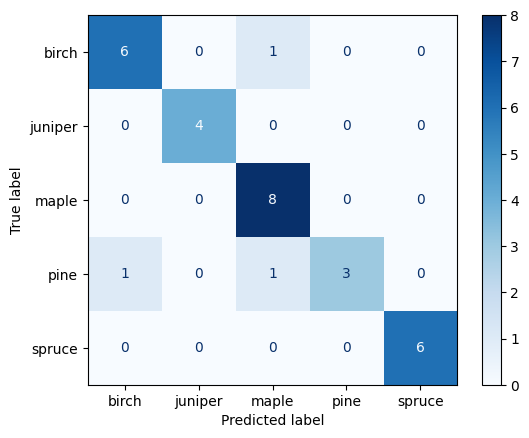

In [30]:
import torch
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Function to get predictions for the entire validation set
def get_all_predictions(model, loader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            all_preds.append(predicted.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    # Convert list of arrays to single numpy arrays
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)
    return all_preds, all_labels

# Get predictions and true labels from validation data
preds, labels = get_all_predictions(model, val_loader, device)
# Print the shape of preds and labels
print(f"Number of predictions: {len(preds)}")
print(f"Number of true labels: {len(labels)}")
# Compute the confusion matrix
conf_matrix = confusion_matrix(labels, preds)

# Display the confusion matrix
class_names = ['birch', 'juniper', 'maple', 'pine', 'spruce']  # Based on your dataset

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.show()
